In [4]:
# from patch_CAVI import *
import numpy as np
import matplotlib.pyplot as plt
import torch
from types import SimpleNamespace
import sys
sys.path.append('..')
from field_of_junctions import FieldOfJunctions
import matplotlib
import cv2
from patch_CAVI_unary import *
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

## CAVI helpers

In [84]:
def func(x):
    x = -x.abs()
    mult = torch.exp(-30.0 * x.max(0, keepdim=True)[0].max(1, keepdim=True)[0] ** 2)
    return mult * 10.0 * torch.exp(3.0 * x)

def reconstruct_img(out,H,W,stride,PSZ):
    rec = np.zeros([H,W,int(out.shape[-2]*out.shape[-1])])
    num_overlaps = np.zeros([H,W])
    itr = 0
    for i in range(out.shape[-2]):
        for j in range(out.shape[-1]):
            rec[i*stride:i*stride + PSZ,j*stride:j*stride + PSZ,itr] = out[...,i,j].detach().cpu().numpy()
            num_overlaps[i*stride:i*stride + PSZ,j*stride:j*stride + PSZ] += 1
            itr = itr+1
    return np.divide(np.sum(rec,axis = -1),num_overlaps)


In [6]:
permutations = patch_multipliers[torch.arange(N).view(-1, 1, 1, 1, 1, 1, 1),
                perm_list.permute(1, 0).view(1, 3, 6, 1, 1, 1, 1),
                torch.arange(1).view(1, 1, -1, 1, 1, 1, 1),
                torch.arange(de.RF).view(1, 1, 1, -1, 1, 1, 1),
                torch.arange(de.RF).view(1, 1, 1, 1, -1, 1, 1),
                torch.arange(H_patches).view(1, 1, 1, 1, 1, -1, 1),
                torch.arange(W_patches).view(1, 1, 1, 1, 1, 1, -1)]

NameError: name 'patch_multipliers' is not defined

## Creating simple FOJ patches

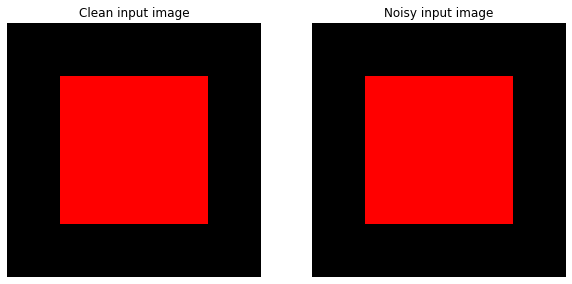

In [7]:
# Red square on black background
clean_img = np.zeros((48, 48, 3), dtype=np.float32)
clean_img[10:-10, 10:-10, 0] = 1.0

# Add noise
img = clean_img + np.random.randn(*clean_img.shape)*0
mn, mx = img.min(), img.max()

# Adjust contrast (equally to both images)
img = (img - mn) / (mx - mn)
clean_img = (clean_img - mn) / (mx - mn)

plt.figure(figsize=[10, 10])
plt.subplot(121)
plt.imshow(clean_img)
plt.title('Clean input image')
plt.axis('off');
plt.subplot(122)
plt.imshow(img)
plt.title('Noisy input image')
plt.axis('off');

SyntaxError: invalid syntax (<ipython-input-3-c2a3404c0366>, line 1)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Beginning initialization...
Initialization iteration 0/30
Initialization iteration 5/30
Initialization iteration 10/30
Initialization iteration 15/30
Initialization iteration 20/30
Initialization iteration 25/30
Initialization done. Beginning refinement...
Refinement iteration 100/1000
Refinement iteration 200/1000
Refinement iteration 300/1000
Refinement iteration 400/1000
Refinement iteration 500/1000
Refinement iteration 600/1000
Refinement iteration 700/1000
Refinement iteration 800/1000
Refinement iteration 900/1000
Refinement iteration 1000/1000
CPU times: user 41min 48s, sys: 42min 46s, total: 1h 24min 34s
Wall time: 16min 21s


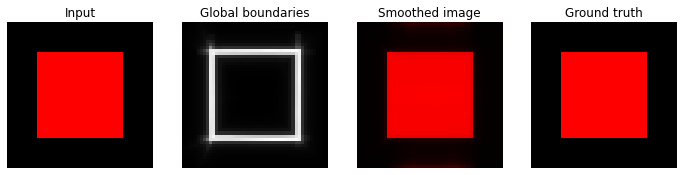

In [8]:
# Create opts object
opts = SimpleNamespace()

opts.R                        = 21
opts.stride                   = 1
opts.eta                      = 0.01
opts.delta                    = 0.05
opts.lr_angles                = 0.003
opts.lr_x0y0                  = 0.03
opts.lambda_boundary_final    = 0.5
opts.lambda_color_final       = 0.1
opts.nvals                    = 31
opts.num_initialization_iters = 30
opts.num_refinement_iters     = 1000
opts.greedy_step_every_iters  = 50
opts.parallel_mode            = True
opts.ang_per_vertex           = 3


# Define function for optimization (foj.optimize() may be used instead)
def foj_optimize_verbose():
    for i in range(foj.num_iters):
        if i == 0:
            print("Beginning initialization...")
        if i == opts.num_initialization_iters:
            print("Initialization done. Beginning refinement...")
        if i < opts.num_initialization_iters:
            if i % 5 == 0:
                print(f"Initialization iteration {i}/{opts.num_initialization_iters}")
        else:
            if i % 100 == 0:
                print(f"Refinement iteration {i}/{opts.num_refinement_iters}")
        foj.step(i)

# Create and optimize field of junctions
foj = FieldOfJunctions(img, opts)
%time foj_optimize_verbose()       # Run optimization with some printing

# Compute smoothed image and boundary map
params = torch.cat([foj.angles, foj.x0y0], dim=1)
dists, _, patches = foj.get_dists_and_patches(params)
local_boundaries = foj.dists2boundaries(dists)
global_boundaries = foj.local2global(local_boundaries)[0, 0, :, :].detach().cpu().numpy()
smoothed_img = foj.local2global(patches)[0, :, :, :].permute(1, 2, 0).detach().cpu().numpy()

plt.figure(figsize=[12, 12])
plt.subplot(141)
plt.imshow(img)
plt.title('Input')
plt.axis('off')
plt.subplot(142)
plt.imshow(global_boundaries, cmap='gray')
plt.title('Global boundaries')
plt.axis('off')
plt.subplot(143)
plt.imshow(smoothed_img)
plt.title('Smoothed image')
plt.axis('off')
plt.subplot(144)
plt.imshow(clean_img)
plt.title('Ground truth')
plt.axis('off');

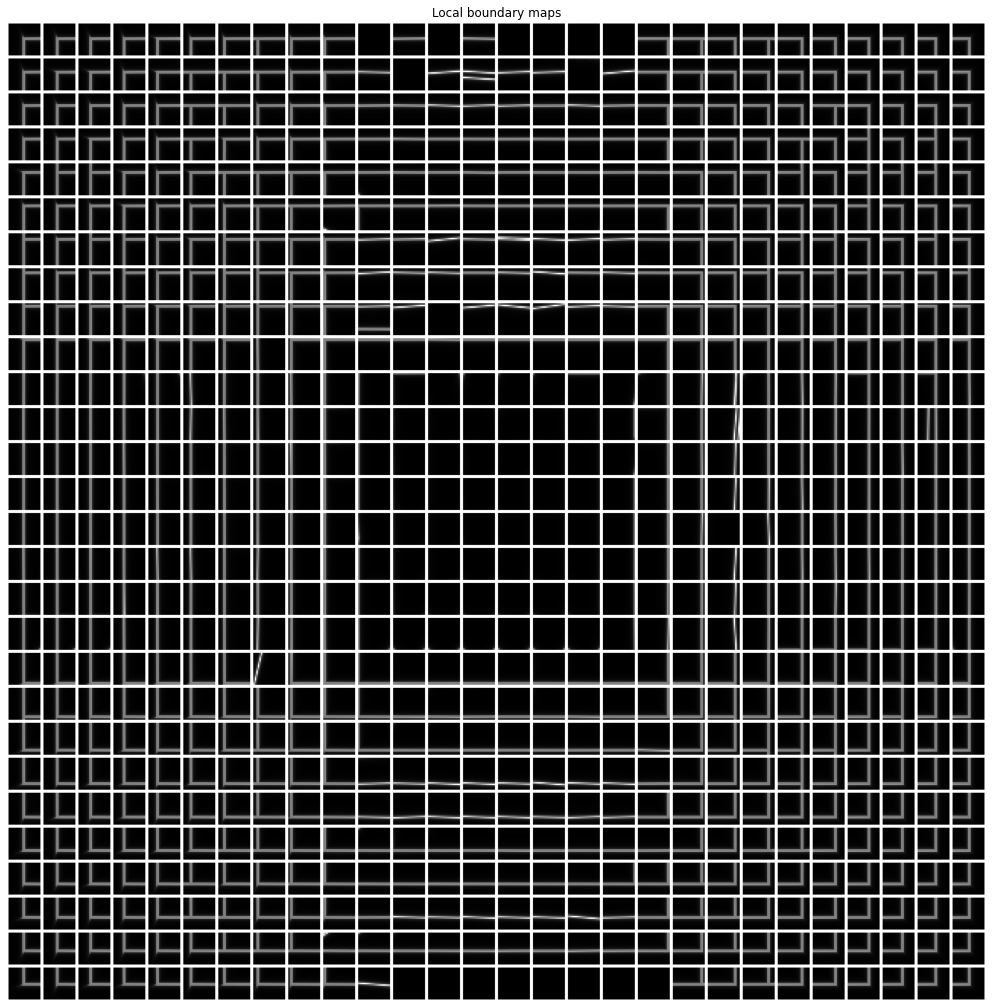

In [10]:
from utils import patchstack

boundary_vis = patchstack(local_boundaries)[0, :, :, :].detach().permute(1, 2, 0).cpu().numpy()
plt.figure(figsize=[18, 18])
plt.imshow(boundary_vis, cmap='gray')
plt.title('Local boundary maps')
plt.axis('off');


In [11]:
angles = torch.remainder(params[:, :3, :, :], 2 * np.pi)
angles = torch.sort(angles, dim=1)[0].detach().cpu().numpy()

t_angle1 = angles[0, 0, :, :]   # shape [N, 1, 1, H', W']
t_angle2 = angles[0, 1, :, :]   # shape [N, 1, 1, H', W']
t_angle3 = angles[0, 2, :, :]  # shape [N, 1, 1, H', W']

#ANGLES ARE SWAPPED BECUASE WEDGES ORDERED COUNTERCLOCKWISE
angle1 = np.remainder(t_angle1-t_angle3,2*np.pi)
angle3 = np.remainder(t_angle2-t_angle1,2*np.pi) 
angle2 = np.remainder(t_angle3-t_angle2,2*np.pi)
anglemat = np.stack((angle1,angle2,angle3),axis = 0)

In [12]:
anglemat.shape

(3, 28, 28)

## Looking at initial wedges and ordering

Vertex position [[-0.04847883 -0.45007837]]
Original Angles [ 1.5723013 12.563175   6.2815   ]


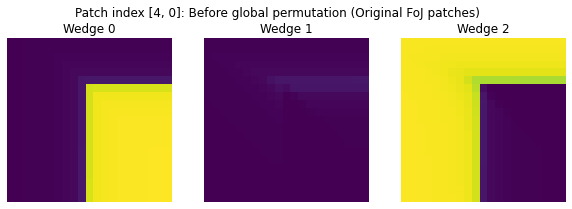

In [230]:
wedges = foj.dists2indicators(dists).detach().cpu().numpy()
# print('wedge shape', wedges.shape)
patch_index = [4,0]
plt.figure(figsize=[10,30])
plt.suptitle(f'Patch index {patch_index}: Before global permutation (Original FoJ patches)')
plt.subplot(131)
plt.imshow(wedges[0,0,:,:,patch_index[0],patch_index[1]],vmin=0,vmax=1)
plt.title('Wedge 0')
plt.axis('off')
plt.subplot(132)
plt.imshow(wedges[0,1,:,:,patch_index[0],patch_index[1]],vmin=0,vmax=1)
plt.title('Wedge 1')
plt.axis('off')
plt.subplot(133)
plt.imshow(wedges[0,2,:,:,patch_index[0],patch_index[1]],vmin=0,vmax=1)
plt.title('Wedge 2')
plt.axis('off')
plt.subplots_adjust(top=1.73)

angles = params[:, :3, :, :].detach().cpu().numpy()


print('Vertex position', params[:, 3:, patch_index[0],patch_index[1]].detach().cpu().numpy())


print('Original Angles', angles[0,:,patch_index[0],patch_index[1]])

# print('Wedge Angles', anglemat[:,patch_index[0],patch_index[1]])

# plt.colorbar()

# print('Wedge Range', np.min(wedges[0,1,:,:,0,0]),np.max(wedges[0,1,:,:,0,0]))

In [61]:
H_patches = wedges.shape[4]
W_patches = wedges.shape[5]
N=1

In [62]:
#Use wedges to create region patches, use these patches to create permutations

wedges = foj.dists2indicators(dists).detach().cpu()
region_patches = wedges.unsqueeze(1).unsqueeze(3)
permutations = get_permutations(region_patches)

In [63]:
idxs = resolve_permutations_mrf(permutations, stride=1, neighborhood=8, max_iters=None, func=func, func2=func, seed=[0,0])

In [64]:
idxs.shape

torch.Size([28, 28])

In [65]:
perm_list[idxs].shape

torch.Size([28, 28, 3])

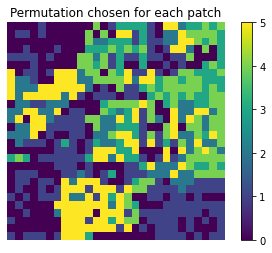

In [66]:
plt.imshow(idxs)
plt.axis('off')
plt.title('Permutation chosen for each patch')
plt.colorbar()
plt.show()

In [67]:
perm_tensor = perm_list[idxs].view(1,1,1,1,H_patches,W_patches,3)
perm_tensor = perm_tensor.repeat(1,1,opts.R,opts.R,1,1,1)
perm_tensor.shape 

torch.Size([1, 1, 21, 21, 28, 28, 3])

In [68]:
perm_list[idxs];

In [69]:
wedges = foj.dists2indicators(dists).detach().cpu()
perm_wedges = wedges.unsqueeze(-1).swapdims(1,6)

In [70]:
perm_wedges.shape

torch.Size([1, 1, 21, 21, 28, 28, 3])

In [71]:
sort_wedges = perm_wedges[0,0,:,:,idxs]

In [72]:
sort_wedges.shape

torch.Size([21, 21, 28, 28, 28, 3])

In [73]:
idxs.shape

torch.Size([28, 28])

In [74]:
test = torch.tensor([0,1,2]).view(1,1,-1).repeat(28,28,1)
test[perm_list[idxs]].shape

torch.Size([28, 28, 3, 28, 3])

In [75]:
sorted_wedges = torch.gather(perm_wedges, -1, perm_tensor)
sorted_wedges = sorted_wedges.swapdims(1,6).squeeze(-1)
sorted_wedges.shape

torch.Size([1, 3, 21, 21, 28, 28])

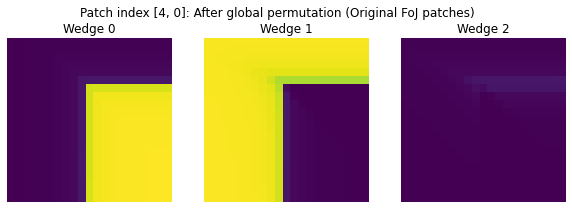

In [233]:

patch_index = [4,0]
plt.figure(figsize=[10,30])
plt.suptitle(f'Patch index {patch_index}: After global permutation (Original FoJ patches)')
plt.subplot(131)
plt.imshow(sorted_wedges[0,0,:,:,patch_index[0],patch_index[1]],vmin=0,vmax=1)
plt.title('Wedge 0')
plt.axis('off')
plt.subplot(132)
plt.imshow(sorted_wedges[0,1,:,:,patch_index[0],patch_index[1]],vmin=0,vmax=1)
plt.title('Wedge 1')
plt.axis('off')
plt.subplot(133)
plt.imshow(sorted_wedges[0,2,:,:,patch_index[0],patch_index[1]],vmin=0,vmax=1)
plt.title('Wedge 2')
plt.axis('off')
plt.subplots_adjust(top=1.73)


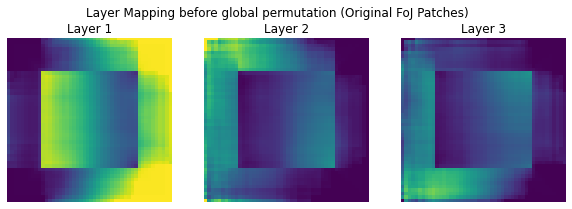

In [91]:
reconstruct_1 = reconstruct_img(wedges[0,0,...],48,48,opts.stride,opts.R)
reconstruct_2 = reconstruct_img(wedges[0,1,...],48,48,opts.stride,opts.R)
reconstruct_3 = reconstruct_img(wedges[0,2,...],48,48,opts.stride,opts.R)

plt.figure(figsize=[10,30])
plt.subplot(131)
plt.imshow(reconstruct_1,vmin=0,vmax=1)
# plt.colorbar()
plt.axis('off')
plt.title('Layer 1')
plt.subplot(132)
plt.imshow(reconstruct_2,vmin=0,vmax=1)
# plt.colorbar()
plt.axis('off')
plt.title('Layer 2')
plt.subplot(133)
plt.imshow(reconstruct_3,vmin=0,vmax=1)
# plt.colorbar()
plt.axis('off')
plt.title('Layer 3')
plt.suptitle('Layer Mapping before global permutation (Original FoJ Patches)')
plt.subplots_adjust(top=1.73)

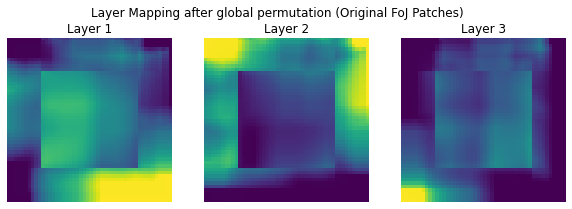

In [92]:
reconstruct_1 = reconstruct_img(sorted_wedges[0,0,...],48,48,opts.stride,opts.R)
reconstruct_2 = reconstruct_img(sorted_wedges[0,1,...],48,48,opts.stride,opts.R)
reconstruct_3 = reconstruct_img(sorted_wedges[0,2,...],48,48,opts.stride,opts.R)

plt.figure(figsize=[10,30])
plt.subplot(131)
plt.imshow(reconstruct_1,vmin=0,vmax=1)
# plt.colorbar()
plt.axis('off')
plt.title('Layer 1')
plt.subplot(132)
plt.imshow(reconstruct_2,vmin=0,vmax=1)
# plt.colorbar()
plt.axis('off')
plt.title('Layer 2')
plt.subplot(133)
plt.imshow(reconstruct_3,vmin=0,vmax=1)
# plt.colorbar()
plt.axis('off')
plt.title('Layer 3')
plt.suptitle('Layer Mapping after global permutation (Original FoJ Patches)')
plt.subplots_adjust(top=1.73)

In [30]:
sorted_angles = -1*torch.tensor(np.sort(-anglemat,axis=0))

## Next part: Sort by wedge size

In [31]:
ang_sort_idx = torch.tensor(np.argsort(-anglemat,axis=0))
# angles_ascending = np.take_along_axis(useful_angles, ang_sort_idx, axis=0)
ang_sort_idx = ang_sort_idx.unsqueeze(-1).swapdims(0,3).squeeze(0)
ang_sort_idx = ang_sort_idx.view(1,1,1,1,H_patches,W_patches,3)
ang_sort_idx = ang_sort_idx.repeat(1,1,opts.R,opts.R,1,1,1)
ang_sort_idx.shape

torch.Size([1, 1, 21, 21, 28, 28, 3])

In [32]:
ang_sorted_wedges_resh = torch.gather(perm_wedges, -1, ang_sort_idx)
ang_sorted_wedges = ang_sorted_wedges_resh.swapdims(1,6).squeeze(-1)


In [33]:
ang_region_patches = ang_sorted_wedges.unsqueeze(1).unsqueeze(3)
ang_permutations = get_permutations(ang_region_patches)

In [34]:
ang_idxs = resolve_permutations_mrf(ang_permutations, stride=1, neighborhood=8, max_iters=1000, func=func, func2=func, seed=[15,15])

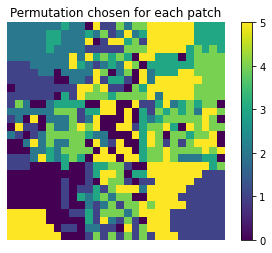

In [35]:
plt.imshow(ang_idxs)
plt.axis('off')
plt.title('Permutation chosen for each patch')
plt.colorbar()
plt.show()

In [38]:
ang_perm_tensor = perm_list[ang_idxs].view(1,1,1,1,H_patches,W_patches,3)
ang_perm_tensor = ang_perm_tensor.repeat(1,1,opts.R,opts.R,1,1,1)

ang_perm_wedges_resh = torch.gather(perm_wedges, -1, ang_perm_tensor)
ang_perm_wedges = ang_perm_wedges_resh.swapdims(1,6).squeeze(-1)



Vertex position [[-0.04847883 -0.45007837]]
Wedge Angles tensor([4.7077e+00, 1.5740e+00, 1.5101e-03])


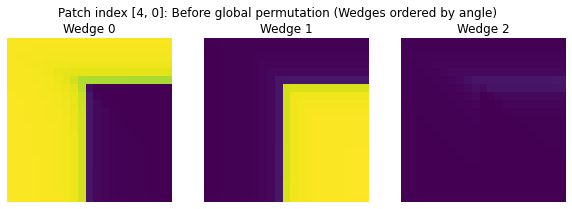

In [125]:
patch_index = [4,0]
plt.figure(figsize=[10,30])
plt.suptitle(f'Patch index {patch_index}: Before global permutation (Wedges ordered by angle)')
plt.subplot(131)
plt.imshow(ang_sorted_wedges[0,0,:,:,patch_index[0],patch_index[1]],vmin=0,vmax=1)
plt.title('Wedge 0')
plt.axis('off')
plt.subplot(132)
plt.imshow(ang_sorted_wedges[0,1,:,:,patch_index[0],patch_index[1]],vmin=0,vmax=1)
plt.title('Wedge 1')
plt.axis('off')
plt.subplot(133)
plt.imshow(ang_sorted_wedges[0,2,:,:,patch_index[0],patch_index[1]],vmin=0,vmax=1)
plt.title('Wedge 2')
plt.axis('off')
plt.subplots_adjust(top=1.73)
print('Vertex position', params[:, 3:, patch_index[0],patch_index[1]].detach().cpu().numpy())
print('Wedge Angles', sorted_angles[:,patch_index[0],patch_index[1]])

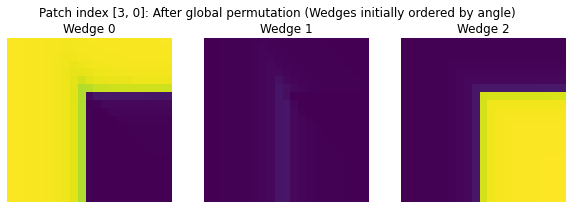

In [131]:
patch_index = [3,0]
plt.figure(figsize=[10,30])
plt.suptitle(f'Patch index {patch_index}: After global permutation (Wedges initially ordered by angle)')
plt.subplot(131)
plt.imshow(ang_perm_wedges[0,0,:,:,patch_index[0],patch_index[1]],vmin=0,vmax=1)
plt.title('Wedge 0')
plt.axis('off')
plt.subplot(132)
plt.imshow(ang_perm_wedges[0,1,:,:,patch_index[0],patch_index[1]],vmin=0,vmax=1)
plt.title('Wedge 1')
plt.axis('off')
plt.subplot(133)
plt.imshow(ang_perm_wedges[0,2,:,:,patch_index[0],patch_index[1]],vmin=0,vmax=1)
plt.title('Wedge 2')
plt.axis('off')
plt.subplots_adjust(top=1.73)


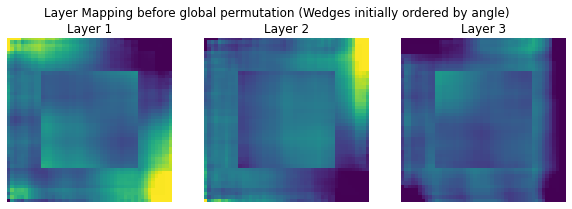

In [121]:
reconstruct_1 = reconstruct_img(ang_perm_wedges[0,0,...],48,48,opts.stride,opts.R)
reconstruct_2 = reconstruct_img(ang_perm_wedges[0,1,...],48,48,opts.stride,opts.R)
reconstruct_3 = reconstruct_img(ang_perm_wedges[0,2,...],48,48,opts.stride,opts.R)

plt.figure(figsize=[10,30])
plt.subplot(131)
plt.imshow(reconstruct_1,vmin=0,vmax=1)
# plt.colorbar()
plt.axis('off')
plt.title('Layer 1')
plt.subplot(132)
plt.imshow(reconstruct_2,vmin=0,vmax=1)
# plt.colorbar()
plt.axis('off')
plt.title('Layer 2')
plt.subplot(133)
plt.imshow(reconstruct_3,vmin=0,vmax=1)
# plt.colorbar()
plt.axis('off')
plt.title('Layer 3')
plt.suptitle('Layer Mapping before global permutation (Wedges initially ordered by angle)')
plt.subplots_adjust(top=1.73)

In [41]:
ang_idxs[patch_index[0],patch_index[1]]

tensor(0)

## Creating unary potentials

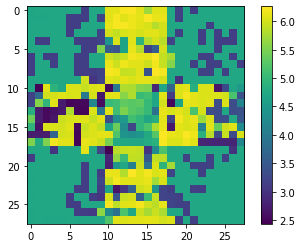

In [42]:
plt.imshow(sorted_angles[0,...].numpy())
plt.colorbar()

In [43]:
sorted_angles = -1*torch.tensor(np.sort(-anglemat,axis=0))
epsilon_0 = .3
epsilon_2 = .3

out_of_bounds = torch.max(torch.abs(foj.x0y0),axis=1)[0].squeeze(0) 
#Booleans representing the conditionals
w0_pi = torch.abs(sorted_angles[0,...]-torch.pi)<epsilon_0
w1_pi = torch.abs(sorted_angles[1,...]-torch.pi)<epsilon_0
w2_zero = sorted_angles[2,...]<epsilon_2

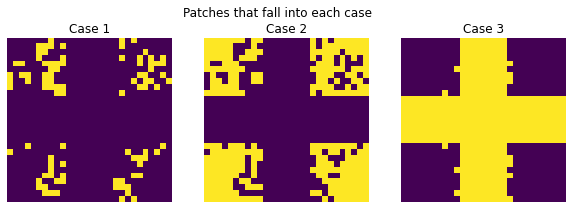

In [105]:
# plt.imshow(w0_pi.numpy())
# plt.imshow((out_of_bounds>1).numpy())
# plt.imshow(out_of_bounds.numpy())

# plt.imshow(w2_zero.numpy())
# torch.sum(w2_zero)


#Locations of Case 1 w0 -> pi, w2 !-> 0
plt.figure(figsize = [10,30])
plt.subplot(131)
plt.imshow(w0_pi.numpy()&  ~w2_zero.numpy()&(out_of_bounds<1).numpy())
plt.axis('off')
plt.title('Case 1')

#Locations of Case 2  w2 -> 0
plt.subplot(132)
plt.imshow(w2_zero.numpy() &~w1_pi.numpy()&(out_of_bounds<1).numpy())
plt.axis('off')
plt.title('Case 2')

#Locations of Case 3  w0 !-> pi, w2 !-> 0
plt.subplot(133)
plt.imshow((~w0_pi.numpy()& ~w2_zero.numpy())|(out_of_bounds>1).numpy())
plt.axis('off')
plt.title('Case 3')

plt.suptitle('Patches that fall into each case')
plt.subplots_adjust(top=1.73)


In [45]:
unary_pots = np.zeros((6,*w2_zero.numpy().shape))
unary_pots[:,w0_pi.numpy()& ~w2_zero.numpy()] = np.array([[0,0,1,1,1,1]]).T
unary_pots[:,w2_zero.numpy()] = np.array([[0,0,0,1,1,1]]).T
unary_pots[:,~w0_pi.numpy()& ~w2_zero.numpy()] = np.array([[0,0,0,0,0,0]]).T

#Inverting
unary_pots = np.zeros((6,*w2_zero.numpy().shape)) 
unary_pots[:,w0_pi.numpy()& ~w2_zero.numpy()] = np.array([[1,1,0,0,0,0]]).T
unary_pots[:,w2_zero.numpy()&~w1_pi.numpy()] = np.array([[0,0,1,1,0,1]]).T
unary_pots[:,(~w0_pi.numpy()& ~w2_zero.numpy())|(out_of_bounds>1).numpy()] = np.array([[0,0,0,0,0,0]]).T

In [46]:
unary_pots.shape

(6, 28, 28)

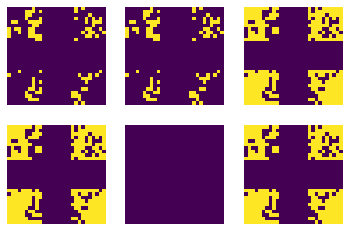

In [47]:
for itr in range(unary_pots.shape[0]):
    plt.subplot(2,3,itr+1)
    plt.imshow(unary_pots[itr,:,:])
    plt.axis('off')

In [333]:
ang_idxs_unary = resolve_permutations_mrf(ang_permutations, stride=1, neighborhood=8, max_iters=1000,unary = .000001*unary_pots,  func=func, func2=func, seed=[0,15])

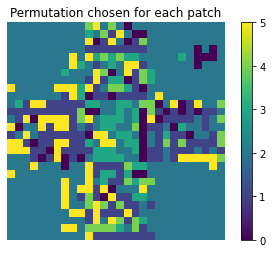

In [223]:
plt.imshow(ang_idxs_unary)
plt.axis('off')
plt.title('Permutation chosen for each patch')
plt.colorbar()
plt.show()

In [334]:
ang_perm_tensor_unary = perm_list[ang_idxs_unary].view(1,1,1,1,H_patches,W_patches,3)
ang_perm_tensor_unary = ang_perm_tensor_unary.repeat(1,1,opts.R,opts.R,1,1,1)

ang_perm_wedges_unary = torch.gather(ang_sorted_wedges_resh, -1, ang_perm_tensor_unary)
ang_perm_wedges_unary = ang_perm_wedges_unary.swapdims(1,6).squeeze(6)


In [225]:
ang_idxs_unary[16,0]
unary_pots[:,16,0]

array([0., 0., 0., 0., 0., 0.])

In [226]:
# @interactive
def plot_wedges(patch_idx_x =27, patch_idx_y = 0):
    patch_index = [patch_idx_x,patch_idx_y]
    plt.figure(figsize=[10,30])
    plt.suptitle(f'Patch index {patch_index}:  After global permutation with unary potentials (Wedges ordered by angle)')
    plt.subplot(131)
    plt.imshow(ang_perm_wedges_unary[0,0,:,:,patch_index[0],patch_index[1]],vmin=0,vmax=1)
    plt.title('Wedge 0')
    plt.axis('off')
    plt.subplot(132)
    plt.imshow(ang_perm_wedges_unary[0,1,:,:,patch_index[0],patch_index[1]],vmin=0,vmax=1)
    plt.title('Wedge 1')
    plt.axis('off')
    plt.subplot(133)
    plt.imshow(ang_perm_wedges_unary[0,2,:,:,patch_index[0],patch_index[1]],vmin=0,vmax=1)
    plt.title('Wedge 2')
    plt.axis('off')
    plt.subplots_adjust(top=1.73)

for itr in range(28):
#     plot_wedges(patch_idx_x =itr, patch_idx_y = 0)

IndentationError: expected an indented block (<ipython-input-226-c1cb72a30a53>, line 21)

In [ ]:
def reconstruct_img(out,H,W,stride,PSZ):
    rec = np.zeros([H,W,int(out.shape[-2]*out.shape[-1])])
    num_overlaps = np.zeros([H,W])
    itr = 0
    for i in range(out.shape[-2]):
        for j in range(out.shape[-1]):
            rec[i*stride:i*stride + PSZ,j*stride:j*stride + PSZ,itr] = out[...,i,j].detach().cpu().numpy()
            num_overlaps[i*stride:i*stride + PSZ,j*stride:j*stride + PSZ] += 1
            itr = itr+1
    return np.divide(np.sum(rec,axis = -1),num_overlaps)


In [ ]:
ang_perm_wedges_unary[0,0,...].shape

In [ ]:
wedge_out_unary_1 = reconstruct_img(ang_perm_wedges_unary[0,0,...],48,48,opts.stride,opts.R)
wedge_out_1 =  reconstruct_img(ang_perm_wedges[0,0,...],48,48,opts.stride,opts.R)

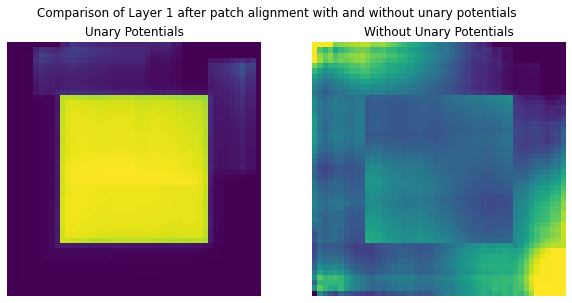

In [227]:
plt.figure(figsize=[10,30])
plt.subplot(121)
plt.imshow(wedge_out_unary_1,vmin=0,vmax=1)
# plt.colorbar()
plt.axis('off')
plt.title('Unary Potentials')
plt.subplot(122)
plt.imshow(wedge_out_1,vmin=0,vmax=1)
plt.axis('off')
plt.title('Without Unary Potentials')
plt.suptitle('Comparison of Layer 1 after patch alignment with and without unary potentials')
plt.subplots_adjust(top=1.685)

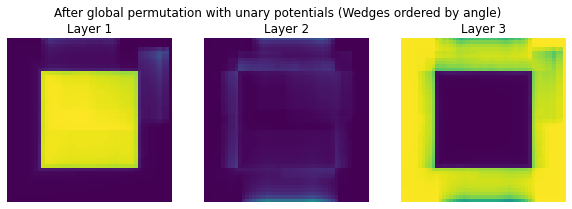

In [335]:
reconstruct_1 = reconstruct_img(ang_perm_wedges_unary[0,0,...],48,48,opts.stride,opts.R)
reconstruct_2 = reconstruct_img(ang_perm_wedges_unary[0,1,...],48,48,opts.stride,opts.R)
reconstruct_3 = reconstruct_img(ang_perm_wedges_unary[0,2,...],48,48,opts.stride,opts.R)

plt.figure(figsize=[10,30])
plt.subplot(131)
plt.imshow(reconstruct_1,vmin=0,vmax=1)
# plt.colorbar()
plt.axis('off')
plt.title('Layer 1')
plt.subplot(132)
plt.imshow(reconstruct_2,vmin=0,vmax=1)
# plt.colorbar()
plt.axis('off')
plt.title('Layer 2')
plt.subplot(133)
plt.imshow(reconstruct_3,vmin=0,vmax=1)
# plt.colorbar()
plt.axis('off')
plt.title('Layer 3')
plt.suptitle('After global permutation with unary potentials (Wedges ordered by angle)')
plt.subplots_adjust(top=1.73)

ValueError: too many values to unpack (expected 2)

In [371]:
def local_resolve_permutations_mrf(permutations, stride, neighborhood=4, unary = None, max_iters=None, func=None, func2=None, seed=None):
    """
    #region_patches has shape [1, 1, 3, 1, RF, RF, H_patches, W_patches]
    permutations has shape [3, 6, RF, RF, H_patches, W_patches]
    """

    assert neighborhood in [4, 8], "neighborhood must be 4 or 8"

    H_patches = permutations.shape[-2]
    W_patches = permutations.shape[-1]

    RF = permutations.shape[-3]
    assert permutations.shape[-4] == RF, "RF must be square"

    if func is None:
        func = lambda x: 10.0 * torch.exp(-100.0 * x)

    if func2 is None:
        func2 = lambda x: 10.0 * torch.exp(-100.0 * x)

    if max_iters is None:
        max_iters = 2 * max([W_patches, H_patches])

    # Create a 6x6xHx(W-1) array of log pairwise potentials for horizontal edges
    # and a 6x6x(H-1)xW array for vertical ones.

    # horizontal_logpsi[k, l, i, j] is the log psi function between the (i, j) and (i, j+1) patches evaluated at
    # the kth and lth permutation respectively.
    horizontal_logpsi = func((permutations[:, :, :, stride:, :, :-1].unsqueeze(2) -
                              permutations[:, :, :, :-stride, :, 1:].unsqueeze(1)).abs().sum(0).mean(2).mean(2))

    # vertical_logpsi[k, l, i, j] is the log psi function between the (i, j) and (i+1, j) patches evaluated at
    # the kth and lth permutation respectively.
    vertical_logpsi = func((permutations[:, :, stride:, :, :-1, :].unsqueeze(2) -
                            permutations[:, :, :-stride, :, 1:, :].unsqueeze(1)).abs().sum(0).mean(2).mean(2))

    # Add padding to avoid having to deal with image boundaries
    horizontal_logpsi = torch.nn.functional.pad(horizontal_logpsi, pad=(1, 1, 1, 1))
    vertical_logpsi = torch.nn.functional.pad(vertical_logpsi, pad=(1, 1, 1, 1))

    if neighborhood == 8:
        # angle45_logpsi[k, l, i, j] is the log psi function between the (i, j) and (i+1, j+1) patches evaluated at
        # the kth and lth permutations respectively.
        angle45_logpsi = func2((permutations[:, :, stride:, stride:, :-1, :-1].unsqueeze(2) -
                                permutations[:, :, :-stride, :-stride, 1:, 1:].unsqueeze(1)).abs().sum(0).mean(2).mean(
            2))

        # angle135_logpsi[k, l, i, j] is the log psi function between the (i, j+1) and (i+1, j) patches evaluated at
        # the kth and lth permutations respectively. [Note: This is a shifted version of the match between (i, j) and (i+1, j-1).]
        angle135_logpsi = func2((permutations[:, :, stride:, :-stride, :-1, 1:].unsqueeze(2) -
                                 permutations[:, :, :-stride, stride:, 1:, :-1].unsqueeze(1)).abs().sum(0).mean(2).mean(
            2))

        # Add padding to avoid having to deal with image boundaries
        angle45_logpsi = torch.nn.functional.pad(angle45_logpsi, pad=(1, 1, 1, 1))
        angle135_logpsi = torch.nn.functional.pad(angle135_logpsi, pad=(1, 1, 1, 1))

    # Set all distributions to uniform except seed which is set to [1, 0, 0, 0, 0, 0].
    lmbdas = torch.ones((6, H_patches + 2, W_patches + 2), dtype=torch.float32).to(permutations.device) / 6.0

    # Unless specified, set seed to the non-constant patch closest to center
    if seed is None:
        # Find patches with at least 2 colors (i.e. no uniform region)
        good_patches = permutations[:, 0, :, :, :, :].max(dim=-3)[0].max(dim=-3)[0].sum(0) > 1.5

        # Find closest such patch to the center
        good_patch_inds = good_patches.nonzero()
        if len(good_patch_inds.shape) < 2:
            seed = (H_patches // 2, W_patches // 2)
        else:
            gpiy = good_patch_inds[:, 0] - (H_patches - 1) / 2.0
            gpix = good_patch_inds[:, 1] - (W_patches - 1) / 2.0
            ind = torch.argmin(gpix ** 2 + gpiy ** 2)

            seed = good_patch_inds[ind, :]

    lmbdas[0, seed[0] + 1, seed[1] + 1] = 1.0
    lmbdas[1:, seed[0] + 1, seed[1] + 1] = 0.0
    for t in range(max_iters):

        # Left neighbor:   sum over permutations of the (i, j-1)th patch, i.e. dimension 0
        s = (lmbdas.unsqueeze(1)[:, :, 1:-1, :-2] * horizontal_logpsi[:, :, 1:-1, :-1]).sum(dim=0)
        # Right neighbor:  sum over permutations of the (i, j+1)th patch, i.e. dimension 1
        s += (lmbdas.unsqueeze(0)[:, :, 1:-1, 2:] * horizontal_logpsi[:, :, 1:-1, 1:]).sum(dim=1)
        # Top neighbor:    sum over permutations of the (i-1, j)th patch, i.e. dimension 0
        s += (lmbdas.unsqueeze(1)[:, :, :-2, 1:-1] * vertical_logpsi[:, :, :-1, 1:-1]).sum(dim=0)
        # Bottom neighbor: sum over permutations of the (i+1, j)th patch, i.e. dimension 1
        s += (lmbdas.unsqueeze(0)[:, :, 2:, 1:-1] * vertical_logpsi[:, :, 1:, 1:-1]).sum(dim=1)

        if neighborhood == 8:
            # TL neighbor: sum over permutations of the (i-1, j-1)th patch, i.e. dimension 0
            s += (lmbdas.unsqueeze(1)[:, :, :-2, :-2] * angle45_logpsi[:, :, :-1, :-1]).sum(dim=0)
            # BR neighbor: sum over permutations of the (i+1, j+1)th patch, i.e. dimension 1
            s += (lmbdas.unsqueeze(0)[:, :, 2:, 2:] * angle45_logpsi[:, :, 1:, 1:]).sum(dim=1)
            # TR neighbor: sum over permutations of the (i-1, j+1)th patch, i.e. dimension 0
            s += (lmbdas.unsqueeze(1)[:, :, :-2, 2:] * angle135_logpsi[:, :, :-1, 1:]).sum(dim=0)
            # BL neighbor: sum over permutations of the (i+1, j-1)th patch, i.e. dimension 1
            s += (lmbdas.unsqueeze(0)[:, :, 2:, :-2] * angle135_logpsi[:, :, 1:, :-1]).sum(dim=1)

        # Update parameters according to CAVI update
        lmbdas[:, 1:-1, 1:-1] = torch.exp(s)


        # Normalize and reset top-left distribution
    
        lmbdas /= lmbdas.sum(dim=0, keepdim=True)
        if unary is not None:
            #Define two argmax terms and check if they are overlapping (if so the chosen permutation is valid)
            t1 = lmbdas[:, 1:-1, 1:-1] == torch.max(lmbdas[:, 1:-1, 1:-1],0)[0].unsqueeze(0).repeat(6,1,1)
            t2 =  unary_pots == torch.max(unary,0)[0].unsqueeze(0).repeat(6,1,1)
            logical_intersect = torch.max(t1*t2,0)[0] #* (t1.sum(dim=0) > t2.sum(dim=0))
            lmbdas[:, 1:-1, 1:-1] += unary * ((max_iters-t)/max_iters)*~logical_intersect #Product term to reduce strength of prior over time
            lmbdas /= lmbdas.sum(dim=0, keepdim=True)

        lmbdas[0, seed[0] + 1, seed[1] + 1] = 1.0
        lmbdas[1:, seed[0] + 1, seed[1] + 1] = 0.0

    lmbdas = lmbdas[:, 1:-1, 1:-1]

    indices = lmbdas.argmax(0)  # shape [H_patches, W_patches]

    return lmbdas,indices

In [372]:
ang_lmbdas, ang_idxs_unary = local_resolve_permutations_mrf(ang_permutations, stride=1, neighborhood=8, max_iters=1000,unary = .000001*unary_pots,  func=func, func2=func, seed=[0,15])
# ang_lmbdas, ang_idxs_unary = local_resolve_permutations_mrf(ang_permutations, stride=1, neighborhood=8, max_iters=1,unary =None,  func=func, func2=func, seed=[0,15])

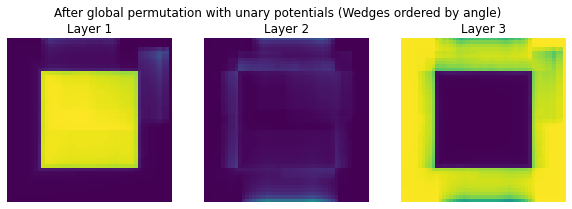

In [373]:
ang_perm_tensor_unary = perm_list[ang_idxs_unary].view(1,1,1,1,H_patches,W_patches,3)
ang_perm_tensor_unary = ang_perm_tensor_unary.repeat(1,1,opts.R,opts.R,1,1,1)

ang_perm_wedges_unary = torch.gather(ang_sorted_wedges_resh, -1, ang_perm_tensor_unary)
ang_perm_wedges_unary = ang_perm_wedges_unary.swapdims(1,6).squeeze(6)

#plotting
reconstruct_1 = reconstruct_img(ang_perm_wedges_unary[0,0,...],48,48,opts.stride,opts.R)
reconstruct_2 = reconstruct_img(ang_perm_wedges_unary[0,1,...],48,48,opts.stride,opts.R)
reconstruct_3 = reconstruct_img(ang_perm_wedges_unary[0,2,...],48,48,opts.stride,opts.R)

plt.figure(figsize=[10,30])
plt.subplot(131)
plt.imshow(reconstruct_1,vmin=0,vmax=1)
# plt.colorbar()
plt.axis('off')
plt.title('Layer 1')
plt.subplot(132)
plt.imshow(reconstruct_2,vmin=0,vmax=1)
# plt.colorbar()
plt.axis('off')
plt.title('Layer 2')
plt.subplot(133)
plt.imshow(reconstruct_3,vmin=0,vmax=1)
# plt.colorbar()
plt.axis('off')
plt.title('Layer 3')
plt.suptitle('After global permutation with unary potentials (Wedges ordered by angle)')
plt.subplots_adjust(top=1.73)

In [292]:
t1 = torch.where(ang_lmbdas == torch.max(ang_lmbdas,0)[0])
torch.tensor(t1)

TypeError: only integer tensors of a single element can be converted to an index

In [308]:
t1 = ang_lmbdas == torch.max(ang_lmbdas,0)[0].unsqueeze(0).repeat(6,1,1)

tensor([[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         False, False, False, False, False, False, False, False,  True,  True,
         False,  True, False,  True,  True,  True,  True,  True],
        [ True, False,  True, False,  True,  True,  True, False,  True,  True,
         False, False, False, False, False, False, False, False, False,  True,
          True, False, False,  True,  True, False,  True,  True],
        [False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         False, False, False, False, False, False, False, False, False,  True,
          True,  True,  True,  True,  True,  True,  True,  True],
        [ True, False,  True,  True, False,  True,  True,  True,  True, False,
         False, False, False, False, False, False, False, False, False,  True,
         False,  True,  True,  True, False, False,  True,  True],
        [False,  True,  True, False,  True,  True,  True, False,  True,  True,
         False, False, Fa

In [311]:
# unary_pots = torch.tensor(unary_pots)
t2 =  unary_pots == torch.max(unary_pots,0)[0].unsqueeze(0).repeat(6,1,1)
t2.shape

torch.Size([6, 28, 28])

In [342]:
ang_lmbdas.sum(dim=0, keepdim=True).shape

torch.Size([1, 28, 28])

In [319]:
logical_intersect = t1*t2
logical_intersect = torch.max(t1*t2,0)[0]

In [326]:
(ang_lmbdas*logical_intersect).shape

torch.Size([6, 28, 28])

In [302]:
torch.where(unary_pots[:,0,0] == torch.max(unary_pots[:,0,0]))

unary_pots.shape

torch.Size([6, 28, 28])